<a href="https://colab.research.google.com/github/Inno732/Defi_IA_1_2023_2024/blob/main/Defi3_2023_2024__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge: Generative AI

In this challenge, three generative models are provided.

For each generative model, you are tasked with answering two questions

## 0. Preconfiguration

In [2]:
import torch

torch.cuda.is_available()

True

If you use Google Colab and the above code returns False, click on `Runtime`, `Change runtime type`, and choose `T4 GPU`. Then run the notebook again from the start.

We install the required libaries.

In [3]:
%pip install --quiet --upgrade diffusers accelerate mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00


We import useful libraries.

In [4]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sklearn.datasets
from pathlib import Path
from tqdm import tqdm
import imageio.v3 as iio

### Dataset visualization

We use the dataset "Labeled Faces in the Wild", which contains more than 13,000 images of faces collected from the web.

We resize them to 36 x 28 to improve the training speed of the models.

The images are composed of 3 channels for the RGB color model, as opposed to 1 channel in MNIST.

In [5]:
data = sklearn.datasets.fetch_lfw_people(resize=0.3, color=True, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)
dataset = data['images'].transpose(0, 3, 1, 2)
transform = transforms.Resize((36, 28), Image.BICUBIC, antialias=True)
dataset = transform(torch.tensor(dataset))
dataset.shape

torch.Size([13233, 3, 36, 28])

We define hyperparameters for the dataset.

In [6]:
size, n_channels, height, width = dataset.shape
X_dim = n_channels * height * width

batch_size = 128
device = 'cuda'

In [7]:
train_set = dataset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We plot a few images of the training dataset.

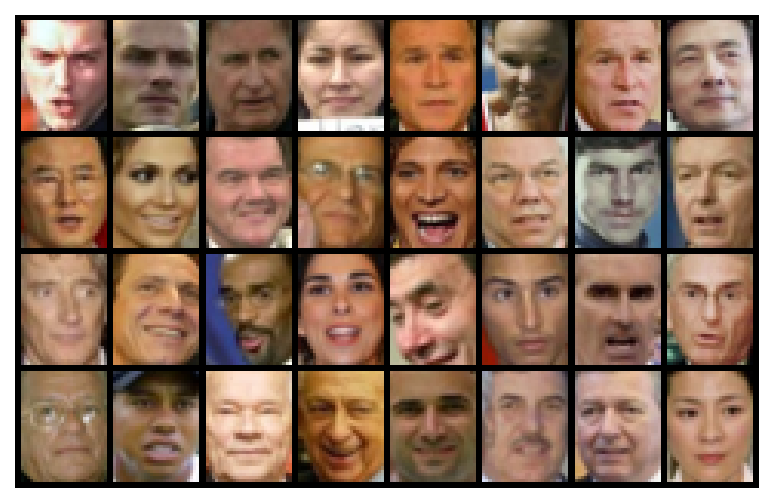

In [8]:
def plot_images(images, ncols=8):
    grid = torchvision.utils.make_grid(images, nrow=ncols)
    # In `make_grid`, `nrow` is a misnomer and represents the number of columns.
    fig, axis = plt.subplots(dpi=150)
    axis.imshow(grid.permute(1, 2, 0), vmin=0, vmax=1)
    axis.axis('off')

rgb_images = next(iter(train_loader))[:32]
plot_images(rgb_images)

## 1. Multivariate Gaussian distribution

We define hyperparameters for the model.

In [40]:
lr = [1e-4 ,1e-3 ,4e-3,8e-3, 1e-2, 1e-1]
nb_epochs = 120

We define a baseline module for estimating the parameters of a multivariate Gaussian distribution with diagonal covariance matrix.
The dimension of this distribution is 3 * 36 * 28, which corresponds to the dimension of an image.

Since the covariance matrix is diagonal, there will be no dependence between the different dimensions of the image.
In other words, the model will naively fit a distribution independently for each pixel of the image.
Thus, we expect this model to have poor sample quality and diversity.

In [41]:
class DiagonalGaussianModule(torch.nn.Module):
    def __init__(self, d):
        super().__init__()
        self.mean = torch.nn.Parameter(torch.randn(d))
        self.rho = torch.nn.Parameter(torch.randn(d))

    def dist(self):
        stddev = torch.nn.Softplus()(self.rho) + 1e-5
        return D.Independent(D.Normal(self.mean, stddev), 1)

Similarly to Lab 1, we perform gradient descent with maximum likelihood estimation.

In [42]:
module = DiagonalGaussianModule(X_dim)

def train(train_loader, lr, nb_epochs):
    loss_list = []

    optimizer = torch.optim.Adam(module.parameters(), lr=lr)
    for epoch in range(nb_epochs):
        for x in train_loader:
            x = x.view(-1, X_dim).float()
            optimizer.zero_grad()
            dist = module.dist()
            # We compute the negative log-likelihood of the samples
            loss = -dist.log_prob(x).mean()
            # We compute the gradients
            loss.backward()
            # We modify the parameters using gradient descent
            optimizer.step()
            loss_list.append(loss.item())
    return loss_list

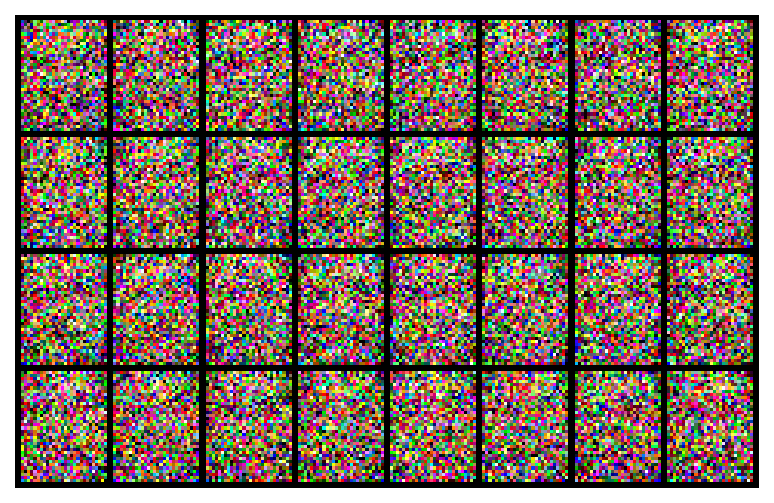

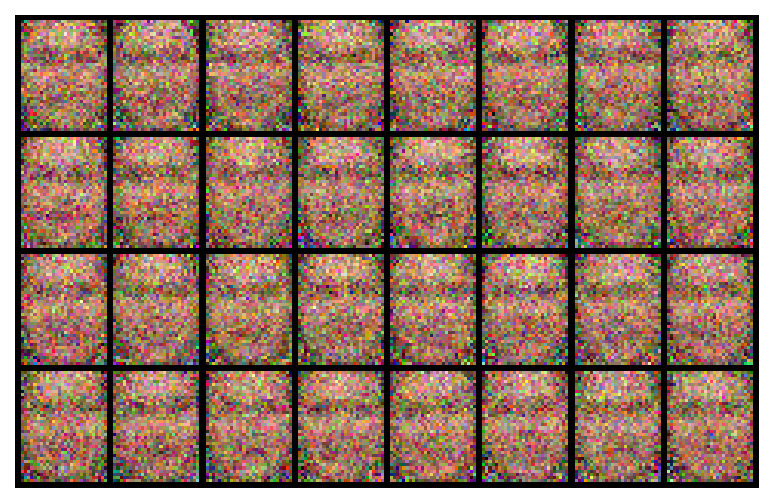

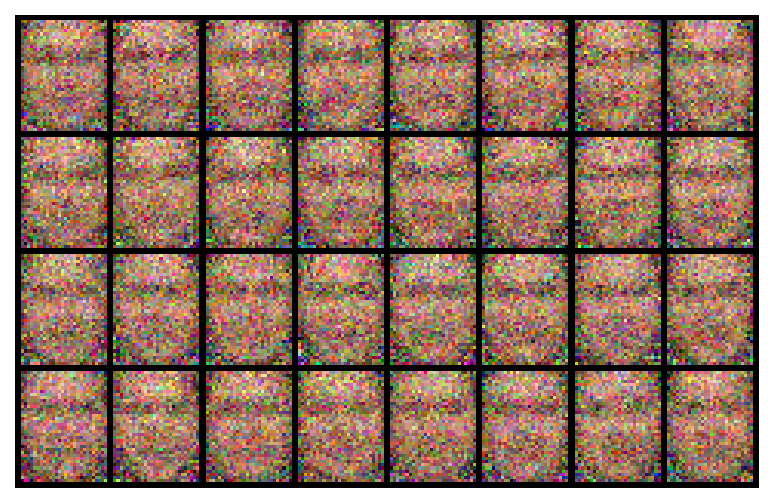

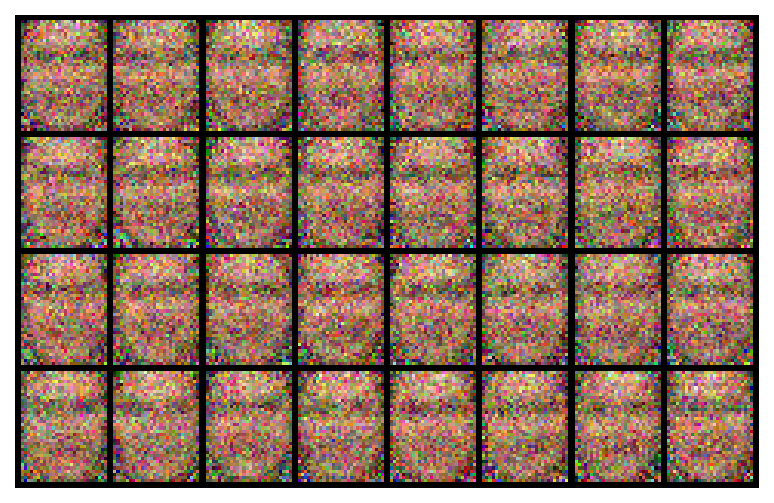

In [43]:
loss_list = []
for i in lr:
  loss_list.append(train(train_loader, lr=i, nb_epochs=nb_epochs))
  sample = module.dist().sample((32,)).detach()
  sample = sample.reshape(-1, n_channels, height, width)
  plot_images(sample)
  plt.show()

We plot the loss per step.

**Q1.1: What can you conclude based on the training curve?**

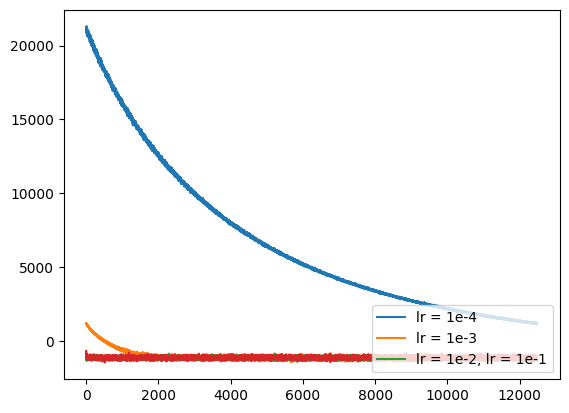

In [44]:
#  Plot the loss and compare
x_vals = range(len(loss_list[0]))
plt.plot(x_vals, loss_list[0])
plt.plot(x_vals, loss_list[1])
plt.plot(x_vals, loss_list[2])
plt.plot(x_vals, loss_list[3])
plt.legend(['lr = 1e-4', 'lr = 1e-3', 'lr = 1e-2, lr = 1e-1'], loc='lower right')
plt.show()

We plot different samples of the distribution. As you can see, there is a lot of noise.

**Q1.2: Which hyperparameters could you modify to improve the quality of the samples? Can you discuss the effect of each of them?**

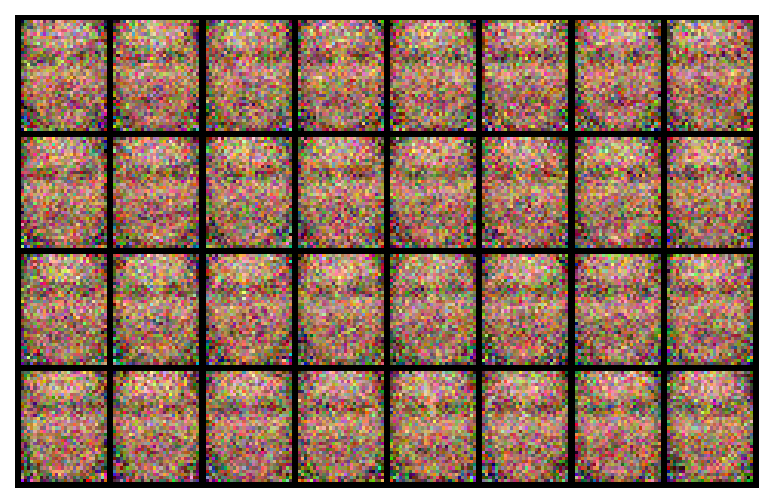

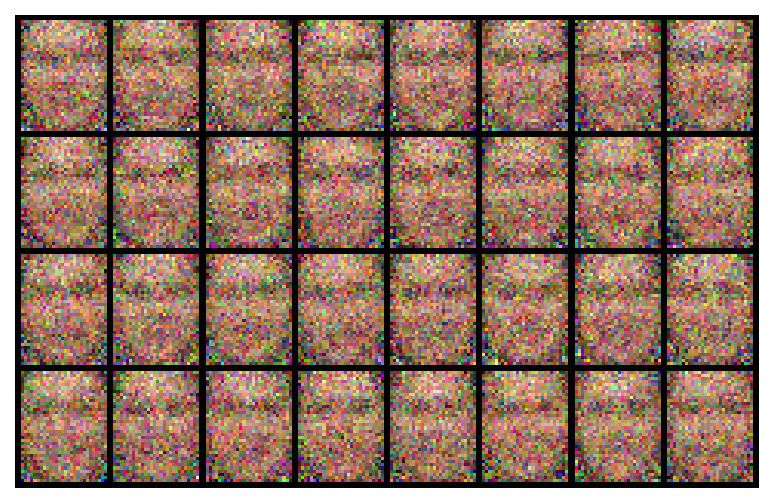

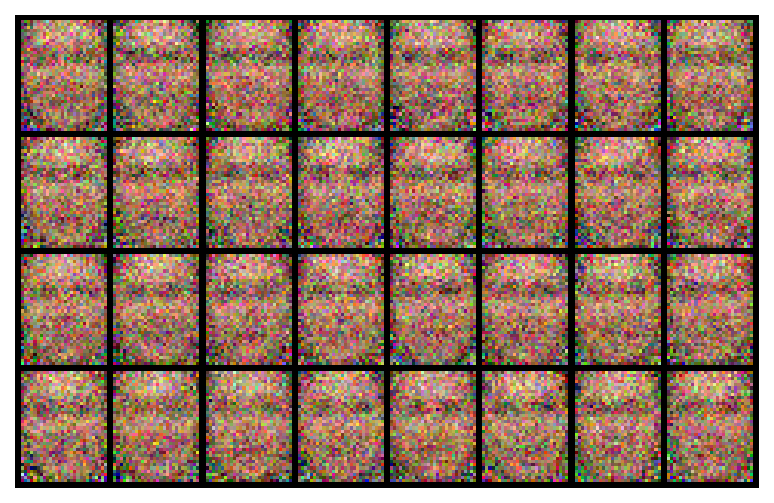

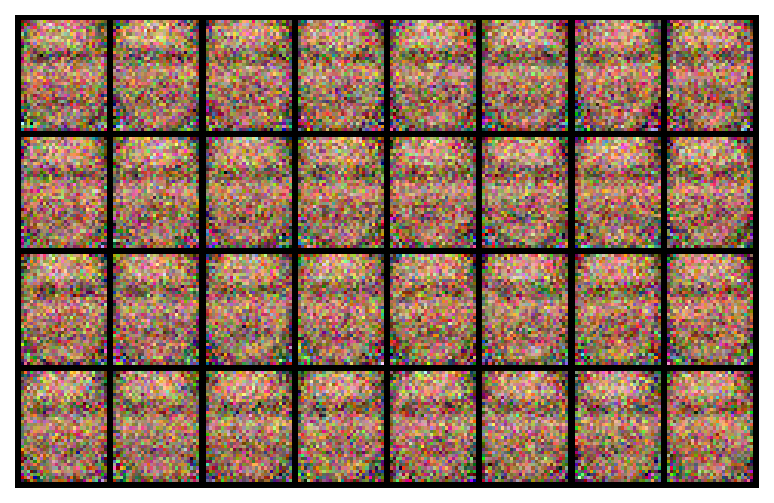

In [14]:
for i in lr:
  train(train_loader, lr=i, nb_epochs=nb_epochs)
  sample = module.dist().sample((32,)).detach()
  sample = sample.reshape(-1, n_channels, height, width)
  plot_images(sample)
  plt.show()

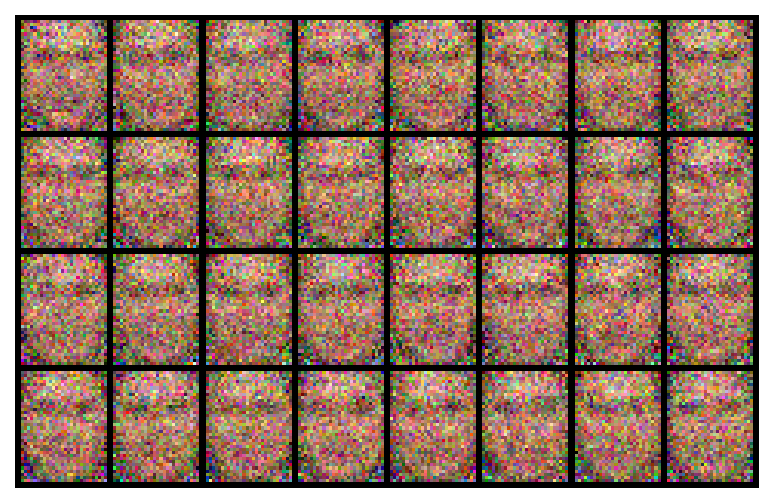

In [63]:
sample = module.dist().sample((32,)).detach()
sample = sample.reshape(-1, n_channels, height, width)
plot_images(sample)
plt.show()

## 2. Variational auto-encoder

Similarly to Lab 2, we define a varitional auto-encoder (VAE).

In [59]:
class Encoder(nn.Module):
    def __init__(self, H_dim, Z_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(X_dim, H_dim),
            nn.LeakyReLU(),
            nn.Linear(H_dim, 2 * Z_dim),
        )

    def forward(self, x):
        x = (x - 0.5) * 2
        mu, rho = torch.chunk(self.model(x), 2, dim=1)
        std = F.softplus(rho)
        return D.Independent(D.Normal(mu, std), 1)


class Decoder(nn.Module):
    def __init__(self, H_dim, Z_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.LeakyReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid(),
            nn.Unflatten(1, (n_channels, height, width)),
        )

    def forward(self, z):
        means = self.model(z)
        return D.Independent(D.Normal(means, torch.ones_like(means)), 3)

We define hyperparameters for the model.

In [60]:
H_dim = 15
Z_dim = 2

We instantiate the encoder and decoder and count the number of parameters.

In [61]:
encoder = Encoder(H_dim, Z_dim).to(device)
decoder = Decoder(H_dim, Z_dim).to(device)

def params_count(model):
    return sum(p.numel() for p in model.parameters())

print('Total parameters of the encoder:', params_count(encoder))
print('Total parameters of the decoder:', params_count(decoder))

Total parameters of the encoder: 45439
Total parameters of the decoder: 48429


The prior distribution is a standard normal distribution over the latent space.

In [62]:
prior = D.Independent(D.Normal(torch.zeros(Z_dim).to(device), torch.ones(Z_dim).to(device)), 1)

The training loop based on gradient descent is defined here.

In [63]:
def train(encoder, decoder, train_loader, num_epochs, lr=1):
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    step = 0
    for epoch in range(num_epochs):
        for x in train_loader:
            x = x.to(device).float()
            # ===== Forward pass =====
            z_dist = encoder(x)
            z = z_dist.rsample()
            x_dist = decoder(z)
            # ===== Loss =====
            reconstruction_loss = -x_dist.log_prob(x).mean()
            complexity_loss = D.kl_divergence(z_dist, prior).mean()
            loss = reconstruction_loss + complexity_loss
            # ===== Backward pass =====
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===== Logging =====
            if step % 100 == 0:
                print(f'epoch [{epoch + 1}/{num_epochs}], step {step + 1}, loss:{loss.item():.4f}')
            step += 1

To avoid waiting, if you already trained a model, you can skip this cell and load a pre-trained model using the next cell.

In [64]:
train(encoder, decoder, train_loader, 10, lr=1e-3)

# Save the model parameters.
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

epoch [1/10], step 1, loss:2856.3499
epoch [1/10], step 101, loss:2824.0742
epoch [2/10], step 201, loss:2813.8540
epoch [3/10], step 301, loss:2813.6404
epoch [4/10], step 401, loss:2812.4580
epoch [5/10], step 501, loss:2810.8037
epoch [6/10], step 601, loss:2810.4622
epoch [7/10], step 701, loss:2811.9688
epoch [8/10], step 801, loss:2809.9917
epoch [9/10], step 901, loss:2811.2534
epoch [10/10], step 1001, loss:2811.3440


Running this cell will load the last model that has been trained.

In [65]:
encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

<All keys matched successfully>

We sample new data points using our trained model.

**Q2.1: Can you experiment with the hyperparameters of this model to improve the quality of the generation?**

You will be able to improve the quality of the samples.
However, keep in mind that, with the current architecture, you will not be able to reach high levels of realism.

**Q2.2: Can you compare the quality of the generations of the VAE with your best model from Section 1?**

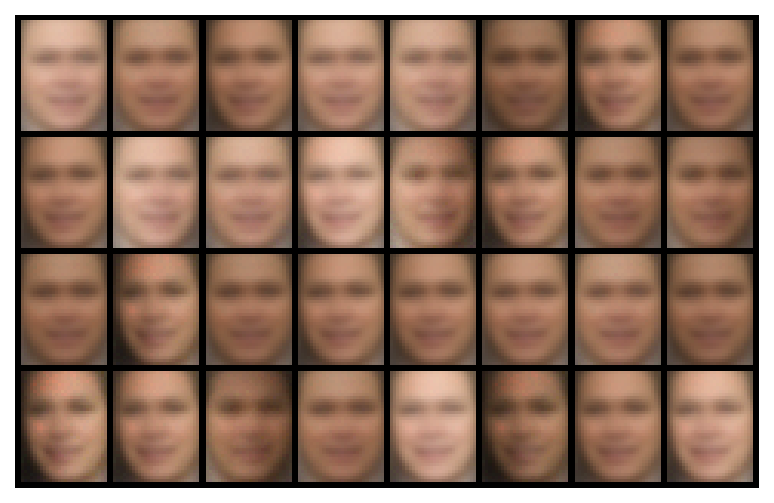

In [66]:
z = prior.sample((32,))
with torch.no_grad():
    sample = decoder(z).mode
plot_images(sample.cpu())
plt.show()

## 3. Diffusion model

We define the hyperparameters of the diffusion model.

In [67]:
n_epoch = 5
lrate = 1e-3
n_T = 400

results_dir = Path('results')
results_dir.mkdir(exist_ok=True)
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

Similarly to Lab 3, we define a UNet and a diffusion model.

In [68]:
from diffusers import UNet2DModel

def create_unet():
    return UNet2DModel(
        sample_size=(height, width),
        in_channels=3,
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(128, 256, 384),
        down_block_types=('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
        up_block_types=('AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    )

unet = create_unet().to(device)

In [69]:
#@title DDPM schedules

def ddpm_schedules(beta1: float, beta2: float, T: int):
    """
    Returns pre-computed schedules for DDPM sampling and training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [70]:
class DDPM(nn.Module):
    def __init__(self, eps_model, betas, n_T):
        super().__init__()
        self.eps_model = eps_model
        self.n_T = n_T

        # We store values of the schedule here.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        t = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(x.device) # Random time step
        noise = torch.randn_like(x) # Noise
        # We apply noise to the input
        x_t = (
            self.sqrtab[t, None, None, None] * x
            + self.sqrtmab[t, None, None, None] * noise
        )
        # We predict the noise that was applied to the input
        pred = self.eps_model(x_t, t / self.n_T)['sample']
        # The loss is defined here
        return nn.MSELoss()(noise, pred)

    def sample(self, n_sample, size, device, save_interval=20) -> torch.Tensor:
        x = torch.randn(n_sample, *size).to(device) # Initial noisy image

        x_per_step = [] # We will save the intermediate results here
        for i in tqdm(range(self.n_T, 0, -1)): # We go backwards in the diffusion process
            t = torch.tensor([i / self.n_T]).to(device) # Current time step
            t = t.repeat(n_sample) # We repeat the time step for each image in the batch

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.eps_model(x, t)['sample'] # We predict the noise
            x = ( # We denoise the image
                self.oneover_sqrta[i] * (x - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i % save_interval == 1:
                x_per_step.append(x)

        return x, torch.stack(x_per_step)

We also define utility functions to plot images and gifs.

In [71]:
#@ Utility functions for plotting

def create_gif(sample_per_step, epoch):
    frames = []
    for sample in sample_per_step:
        frame = torchvision.utils.make_grid(sample, nrow=16)
        #frame = frame.clamp(0, 1)
        frames.append(frame)
    frames = torch.stack(frames).permute(0, 2, 3, 1).numpy()
    frames = (frames * 255).astype(np.uint8)
    iio.imwrite(results_dir / f'sample_diffusion_epoch_{epoch}.gif', frames, duration=100)


def save_samples(ddpm, epoch):
    with torch.no_grad():
        sample, sample_per_step = ddpm.sample(32, (n_channels, height, width), device)
    sample = sample.cpu()
    sample_per_step = sample_per_step.cpu()
    # Rescale the images to [0, 1]
    sample = (sample + 1) / 2
    sample_per_step = (sample_per_step + 1) / 2

    fig = plot_images(sample)
    plt.savefig(results_dir / f'sample_epoch_{epoch}.png')
    plt.close(fig)

    create_gif(sample_per_step, epoch)

We perform gradient descent to optimize the parameters of the UNet.

Note that training a diffusion model can take a long time. For example, training Stable Diffusion would take more than 20,000 hours with an RTX A100, one of the best available GPUs.

In our case, training a good model could take one hour or more.

**Q3.1: Can you experiment with the hyperparameters of this model to improve the quality of the generation? The loss should converge towards 0. Discuss the results that you obtain with different hyperparameters.**

**Q3.2: Can you compare the quality of the generations of the diffusion model with your best model from Section 2?**

In [49]:
ddpm = DDPM(eps_model=unet, betas=(1e-4, 0.02), n_T=n_T).to(device)
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

for epoch in range(n_epoch):
    print(f'Epoch {epoch}')
    ddpm.train()

    # Linear learning rate decay
    optim.param_groups[0]['lr'] = lrate * (1 - epoch / n_epoch)

    pbar = tqdm(train_loader)
    for x in pbar:
        optim.zero_grad()
        x = x.to(device)
        x = x * 2 - 1 # Rescale to [-1, 1]
        loss = ddpm(x)
        loss.backward()
        pbar.set_description(f'Loss: {loss:.4f}')
        optim.step()

    ddpm.eval()
    if epoch % 2 == 0 or epoch == int(n_epoch - 1):
        save_samples(ddpm, epoch) # Save images and gifs
    if epoch % 50 == 0 or epoch == int(n_epoch - 1): # Save checkpoints
        torch.save(ddpm.state_dict(), checkpoint_dir / f'model_{epoch}.pth')

Epoch 0


  0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 400/400 [00:50<00:00,  8.00it/s]


Epoch 1


Loss: 0.0480: 100%|██████████| 104/104 [02:29<00:00,  1.43s/it]


Epoch 2


100%|██████████| 400/400 [00:50<00:00,  7.97it/s]


Epoch 3


Loss: 0.0610: 100%|██████████| 104/104 [02:29<00:00,  1.44s/it]


Epoch 4


100%|██████████| 400/400 [00:50<00:00,  7.97it/s]
